# Quantum Approximate Optimization Algorithm

This notebook is the implementation of Quantum Approximate Optimization Algorithm (QAOA) using Cirq.

This presentation mostly follows [Farhi et al.](https://arxiv.org/abs/1411.4028)


## Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy
import cirq

## Description of QAOA

Suppose you have a function $C(z)$ that depends on a collection of variables $z = z_1,z_2,\ldots, z_n$, where each $z_j$ can be equal to either $+1$ or $-1$ (the important thing here is that each $z_j$ has two possible values, and by convention we choose those values to be $\pm 1$). The QAOA is a general-purpose algorithm whose goal is to produce an assignment of the $z_j$ that gives a relatively low value of $C(z)$. It's not guaranteed to give the lowest possible value of $C(z)$---hence the name "Approximate"---except in a particular limit which we will discuss.

The QAOA algorithm acts on $n$ qubits. As you might guess, each qubit represents one of the variables in our function, and the $2^n$ states of the computational basis correspond to the $2^n$ possible assignments of the $z$ variables. To be more specific, let's agree that the value of $z_j$ corresponds to the measurement outcome of the Pauli-$Z$ operator on the $j$th qubit. There is a potential confusion here because the state $| 0 \rangle$ corresponds to $z = +1$, while the state $| 1\rangle$ corresponds to $z=-1$. This is unfortunate, but is something that we'll just have to deal with.

The QAOA algorithm is fairly simple to explain, though the reasons behind why it works are not obvious at first glance. As usual, we begin with all of our qubits initialized in the $|0\rangle$ state. The first step is to act with $H^{\otimes n}$, the Hadamard operator on each qubit. This prepares an equal superposition of all bitstrings, i.e., an equal superposition of all possible $z$ assignments:
$$
H^{\otimes n} |0^n\rangle =\frac{1}{2^{n/2}} \sum_{x \in \{0,1\}^n} |x\rangle.
$$
This should be thought of as the "real" initial state of the algorithm. The point of the remaining steps is to affect the amplitudes so that those with small $C(z)$ values grow while those with large $C(z)$ values shrink. Then at the end when we measure the qubits we'll be more likely to find a bitstring with a small value of $C(z)$.

The meat of the algorithm relies on the following unitary operator:
$$
U(\gamma,C) = e^{i\pi \gamma C(Z)/2}.
$$
This operator deserves some explanation. First, $\gamma$ is a paramter which we will later treat as a variational parameter, adjusting its value to produce the best possible result. $C$ here is the function we are trying to minimize, and the notation $C(Z)$ is supposed to tell you to plug in the Pauli-$Z$ operator for each qubit in place of the argument $z$. For example, if
$$
C(z) = 3z_1 z_2 - z_2z_3 + z_4
$$
then
$$
C(Z) = 3Z_1 Z_2 - Z_2Z_3 + Z_4.
$$
It looks like I didn't do much, but the point here is that $C(z)$ is a number while $C(Z)$ is a matrix. That matrix is diagonal in the computational basis, and those diagonal entries represent all the possible values of $C(z)$.

After acting with $H^{\otimes n}$, we act with $U(C,\gamma)$. The result is still a sum over all possible bit-strings, but now the coefficients are complex phases which depend on $C$. At this point there is still an equal probability to measure any particular string, though, because Born's rule only depends on the square of the amplitude. So the algorithm is not done yet. Below we will have to figure out how to implement $U(\gamma, C)$ in Cirq so that we can perform this step in the algorithm.

The next step of the algorithm is to act with the unitary operator
$$
U(\beta,B) = e^{i\pi\beta B/2},~~~ B = \sum_{j=1}^n X_j,
$$
where $\beta$ is another variational parameter. Since the Pauli-$X$ operators on each qubit commute with each other, we can alternatively write this as
$$
U(\beta, B) = \prod_{j=1}^n e^{i\pi\beta X_j/2}.
$$
So this is just a rotation of each qubit around the $X$-axis on the Bloch sphere by an amount determined by $\beta$. This operation is _not_ diagonal in the computational basis, and the resulting state will not be an equal superposition over all bitstrings. So after this step there will be constructive and destructive interference, which hopefully leads to enhancement of states corresponding to small values of $C$. This $U(\beta, B)$ is sometimes called a "mixing" operation. Note that, up to an inconsequential global phase, we can also write
$$
U(\beta, B) = \prod_{j=1}^n X_j^{\beta}.
$$

The total circuit consists of repeating the previous two steps a total of $p\geq 1$ times, where the choice of $p$ is up to you. The parameters $\gamma$ and $\beta$ can be chosen independently at each step. So at the conclusion of the circuit, the state of the qubits is
$$
|\gamma,\beta\rangle = U(\beta_p,B)U(\gamma_p,C)\cdots U(\beta_1,B)U(\gamma_1,C)H^{\otimes n}|0^n\rangle.
$$
If we choose $\gamma$ and $\beta$ so that the expectation value
$$
F(\gamma,\beta) = \langle \gamma,\beta|C(Z)|\gamma,\beta\rangle
$$
is minimized, then measuring the state $|\gamma,\beta\rangle$ in the computational basis gives us a good candidate bitstring for the minimum of $C(z)$. That's the whole thing!

In summary we have to perform the following tasks in order to implement the QAOA:


1.   Figure out out to perform the $U(\gamma, C)$ operation in Cirq for our choice of $C$.
2.   Create a quantum circuit alternating $U(\gamma, C)$ and $U(\beta, B)$ operations as many times as desired.
3.   Find the optimal value of the variational parameters in our circuit.
4.   Measure the output of our circuit.

### Toy problem: ground state of Ising model

The Ising Model defines the energy function
$$
E = -\sum_{\langle i,j \rangle} Z_i Z_j - \sum_i h_i Z_i,
$$
where the notation $\langle i,j\rangle$ means a sum over all nearest-neighbor pairs. The picture here is that the qubits live on the vertices of a graph, and the edges of the graph define which qubits are neighbors. We'll just take out graph to be a rectangular lattice with some number of rows and some number of columns. The numbers $h_i$ have the physical interpretation of an external magnetic field.

We are interested in finding a low-lying state of the Ising Model, by which I mean a state that has a relatively low amount of energy. This is a difficult problem in general. The pairwise interaction terms would tell you that neighboring qubits should be in the same state to lower the energy, while the magnetic field terms tell you that a given qubit wants to point "in the same direction" as its local field, and the strength of that preference depends on the magnitude of the field. These two different kinds of pressure are not always in agreement!

This type of problem is a perfect candidate for the QAOA, where we use the energy $E$ as our cost function $C$.

### ZZ Gate

The first thing we need to do is create the operation $U(\gamma, C)$, where $C$ is equal to the Ising Model energy function. The first thing to note is that, since all of the terms in the energy commute, we can decompose this operation as
$$
U(\gamma, C) = \prod_{\langle i,j\rangle}e^{-i\pi\gamma Z_iZ_j/2} \prod_i e^{-i\pi \gamma h_i Z_i/2}.
$$
This requires that we have the two-qubit gate $\exp(-i\pi\gamma ZZ/2)$ at our disposal. In matrix form, this is
$$
\begin{align}
\exp(-i \pi\gamma Z\otimes Z/2) = \begin{bmatrix}
e^{-i\pi \gamma/2}  & 0  &0&0\\
0 & e^{i\pi \gamma/2}   &0&0\\
0&0& e^{i\pi \gamma/2}  &0 \\
0&0 & 0  & e^{-i\pi \gamma/2}
\end{bmatrix}
\end{align}
$$
As of version 0.5.0, Cirq has a built-in gate `cirq.ZZ` which is equivalent to this once you account for a global phase:

In [2]:
a = cirq.NamedQubit('a')
b = cirq.NamedQubit('b')
gamma = 0.5

circuit = cirq.Circuit(cirq.ZZ(a,b)**gamma)

print(circuit)
cirq.unitary(circuit).round(2)

a: ───ZZ───────
      │
b: ───ZZ^0.5───


array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+1.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+1.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

We should also check that the matrix is what we expect

In [3]:
test_matrix = np.array([[np.exp(-1j*np.pi*gamma/2),0, 0, 0],
                        [0, np.exp(1j*np.pi*gamma/2), 0, 0],
                        [0, 0, np.exp(1j*np.pi*gamma/2), 0],
                        [0, 0, 0,np.exp(-1j*np.pi*gamma/2)]])
cirq.testing.assert_allclose_up_to_global_phase(test_matrix, cirq.unitary(circuit), atol=1e-5)

### Z Gate

The magnetic field terms can be handled in a similar way. The single-qubit unitary
$$
\exp(-i\pi \gamma hZ/2) = \begin{bmatrix}
e^{-i\pi \gamma h/2} & 0 \\
0 & e^{i\pi \gamma h/2}
\end{bmatrix}
$$
is equivalent up to global phase to `cirq.Z**(h*gamma)`:

In [4]:
a = cirq.NamedQubit('a')
gamma = 0.5
h = 1.7

circuit = cirq.Circuit(cirq.Z(a)**(gamma*h))

print(circuit)
print(cirq.unitary(circuit).round(2))

test_matrix = np.array([[np.exp(-1j*np.pi*gamma*h/2),0],
                        [0, np.exp(1j*np.pi*gamma*h/2)]])
cirq.testing.assert_allclose_up_to_global_phase(test_matrix, cirq.unitary(circuit), atol=1e-5)

a: ───Z^0.85───
[[ 1.  +0.j    0.  +0.j  ]
 [-0.  +0.j   -0.89+0.45j]]


### Creating Circuit

Using the `cirq.ZZ` gate we can now create the QAOA circuit. We're going to focus on the Ising Model an a rectangular lattice with an arbitrary number of rows and columns. Here are some things to think about:

1.   `cirq.GridQubit`s are natural because our qubits actually do live on a grid. Cirq does not care what kind of qubit you make, though.
2.   It's a good idea to define separate functions to place the C and B layers for the circuit. Really these should be generators that yield the required gates.
3.   You might consider wrapping everything inside a class. We won't do that here, but if you want to play around with different numbers of rows/columns or different numbers of B/C layers it can be convenient.

First we'll define the basic paramters of our model and the generators for the different layers:



In [5]:
n_cols = 3
n_rows = 3
h = 0.5 * np.ones((n_rows, n_cols))

qubits = [[cirq.GridQubit(i, j) for j in range(n_cols)] for i in range(n_rows)]

def beta_layer(beta):
    for row in qubits:
        for qubit in row:
            yield cirq.X(qubit) ** beta


def gamma_layer(gamma, h):
    for i in range(n_rows):
        for j in range(n_cols):
            if i < n_rows-1:
                yield cirq.ZZ(qubits[i][j], qubits[i+1][j])**gamma
            if j < n_cols-1:
                yield cirq.ZZ(qubits[i][j], qubits[i][j+1])
            
            yield cirq.Z(qubits[i][j]) ** (gamma * h[i,j])
        

In [6]:
qaoa = cirq.Circuit()
gamma = sympy.Symbol('g')
beta = sympy.Symbol('b')
qaoa.append(cirq.H.on_each(*[q for row in qubits for q in row]))
qaoa.append(gamma_layer(gamma, h))
qaoa.append(beta_layer(beta))

print(qaoa)

                                               ┌──────────────────┐               ┌──────────────────┐
(0, 0): ───H───ZZ─────ZZ─────Z^(0.5*g)───X^b───────────────────────────────────────────────────────────────────────────────────────────
               │      │
(0, 1): ───H───┼──────ZZ─────ZZ──────────ZZ─────Z^(0.5*g)─────────────X^b──────────────────────────────────────────────────────────────
               │             │           │
(0, 2): ───H───┼─────────────┼───────────ZZ─────ZZ────────────────────Z^(0.5*g)────X^b─────────────────────────────────────────────────
               │             │                  │
(1, 0): ───H───ZZ^g───ZZ─────┼───────────ZZ─────┼────────Z^(0.5*g)────X^b──────────────────────────────────────────────────────────────
                      │      │           │      │
(1, 1): ───H──────────┼──────ZZ^g────────ZZ─────┼────────ZZ───────────ZZ───────────Z^(0.5*g)─────────────X^b───────────────────────────
                      │                         │ 

### Define Expectation Value

To train the QAOA circuit---that is, find the optimal values of the paramters---we're going to need to be able to compute the expectation value of the Ising Model energy. We'll do this within Cirq by defining an energy function. We'll divide the total energy by the number of qubits to keep the numbers under control, basically because we expect the energy to scale with the size of the system.

If we were using real hardware, the only way to compute the expectation value of the energy would be to estimate it by sampling. Using the simulator we can alternatively compute the wavefunction and then get calculate the expectation value from that. Not only does this save us from having to worry about statistical error, it also tends to be faster that simulating the sampling process.

In [7]:
def energy_from_wavefunction(wf, h):
    n_sites = n_rows * n_cols
    
    Z = np.array([(-1)**(np.arange(2**n_sites) >> i) for i in range(n_sites-1,-1,-1)])
    ZZ_filter = np.zeros_like(wf, dtype=float)
    
    for i in range(n_rows):
        for j in range(n_cols):
            if i < n_rows-1:
                ZZ_filter += Z[i*n_cols + j]*Z[(i+1)*n_cols + j]
            if j < n_cols-1:
                ZZ_filter += Z[i*n_cols + j]*Z[i*n_cols + (j+1)]

    energy_operator = -ZZ_filter - h.reshape(n_sites).dot(Z)

    return np.sum(np.abs(wf)**2 * energy_operator) / n_sites

def energy_from_params(gamma, beta, qaoa, h):
    simulation = cirq.Simulator()
    parameters = cirq.ParamResolver({'g':gamma, 'b':beta})
    wf = simulation.simulate(qaoa, param_resolver = parameters).final_state_vector
    
    return energy_from_wavefunction(wf, h)

# Training

Now we need to figure out the best values of $\gamma$ and $\beta$ by minimizing the expectation value of the energy. We'll start by doing a brute-force search of the parameter space for illustrative purposes:

In [8]:
%%time
grid_size = 50
gamma_max = 2
beta_max = 2

energies = np.zeros((grid_size,grid_size))

for i in range(grid_size):
    for j in range(grid_size):
        energies[i,j] = energy_from_params(i*gamma_max/grid_size, j*beta_max/grid_size, qaoa, h)

CPU times: total: 17.2 s
Wall time: 20.2 s


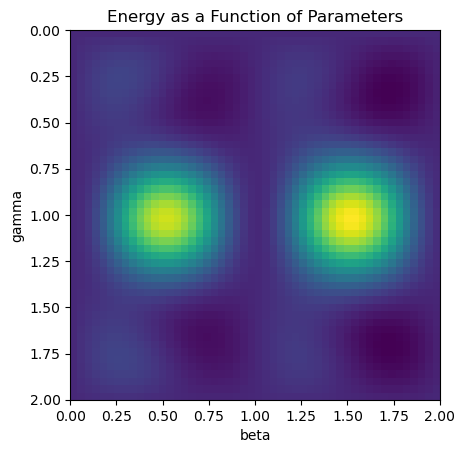

In [9]:
plt.ylabel('gamma')
plt.xlabel('beta')
plt.title('Energy as a Function of Parameters')
plt.imshow(energies, extent = (0,beta_max,gamma_max,0));

By inspection we can see that the energy function has a number of interesting properties. First, note that the function is periodic in $\beta$ and $\gamma$ with shorter periods than one might naively expect given the definition of the gates. The details of why that's true will take us away from the main content of this Colab, but it's a good thing to understand so that the parameter space can be efficiently truncated.

The other main thing to notice is that there are many local minima and maxima. This makes it challenging to use gradient-based methods for optimization. We'll see that explicitly next. Part of the challenge for algorithms of this type is finding efficient ways to optimize the paramters.

#### Gradient Descent

Let's try to minimize the expectation value of the energy using gradient descent. We know that there are local minima that we might get stuck in, depending on initialization, but it's still a worthwhile exercise.

The first step is to define a function which approximates the gradient of the energy. We'll do this by symmetric difference, i.e., $f'(x) \approx (f(x+\epsilon)-f(x-\epsilon))/(2\epsilon)$. You should experiment with different values of $\epsilon$ as well as different formulas for the gradient.

In [10]:
def gradient_energy(gamma, beta, qaoa, h):
    eps = 10**-4

    grad_g = energy_from_params(gamma + eps, beta, qaoa, h)
    grad_g -= energy_from_params(gamma - eps, beta, qaoa, h)
    grad_g /= 2*eps

    grad_b = energy_from_params(gamma, beta + eps, qaoa, h)
    grad_b -= energy_from_params(gamma, beta - eps, qaoa, h)
    grad_b /= 2*eps

    return grad_g, grad_b

In [11]:
gamma, beta = 0.5, 0.6
eta = 10**-3

for i in range(301):
    grad_g, grad_b = gradient_energy(gamma, beta, qaoa, h)
    gamma -= eta*grad_g
    beta -= eta*grad_b
    
    if not i%25:
        print('Step: {} Energy: {}'.format(i, energy_from_params(gamma, beta, qaoa, h)))
print('Learned gamma: {} Learned beta: {}'.format(gamma, beta, qaoa, h))

Step: 0 Energy: -0.047200830382848835
Step: 25 Energy: -0.06792025319559356
Step: 50 Energy: -0.08212279110756368
Step: 75 Energy: -0.0923134922175232
Step: 100 Energy: -0.09988917366981633
Step: 125 Energy: -0.10567143173969068
Step: 150 Energy: -0.1101706893075958
Step: 175 Energy: -0.11371930900149134
Step: 200 Energy: -0.11654627253386075
Step: 225 Energy: -0.11881464290841375
Step: 250 Energy: -0.12064396499315283
Step: 275 Energy: -0.1221235319172062
Step: 300 Energy: -0.12332436113854328
Learned gamma: 0.39239546815398463 Learned beta: 0.6848402718606825


### Results

We've optimized our parameters.

For a $3\times 3$ grid we have $9$ qubits and $12$ interacting nearest-neighbor pairs. If all of the qubits are in the $|0\rangle$ state or all are in the $|1\rangle$ state, then the energy-per-qubit is $-12/9 = -1.33$ at zero external magnetic field $h$, and will be close to that if the magnetic field is small. Notice that the QAOA algorithm we analyzed above is __not__ getting close to that ground state. Is this a problem?

Well, not really. The QAOA algorithm still succeeds if we can  find the ground state after a small numbe of measurements. The QAOA prepares a certain state which is a linear combination of the ground state and many other states. When we measure the qubits, we find the ground-state configuration with some probability. If that probability is relatively large, then after a reasonably small number of measurements we'll locate the ground state.

Practically speaking, this means we should measure the state prepared by the QAOA several times and record the lowest-energy state we find. The QAOA can be successful by biasing these measurements toward the ground state, even if they do not produce the ground state with $100\%$ probability.

Let's make a copy of our qaoa circuit for measurement purposes and attach a measurement gate to each qubit:

In [12]:
measurement_circuit = qaoa.copy()
measurement_circuit.append(cirq.measure(*[qubit for row in qubits for qubit in row],key='m'))
measurement_circuit

┌──────────────────┐               ┌──────────────────┐
(0, 0): ───H───ZZ─────ZZ─────Z^(0.5*g)───X^b───────────────────────────────────────────────────────────────────────────────────────────M('m')───
               │      │                                                                                                                │
(0, 1): ───H───┼──────ZZ─────ZZ──────────ZZ─────Z^(0.5*g)─────────────X^b──────────────────────────────────────────────────────────────M────────
               │             │           │                                                                                             │
(0, 2): ───H───┼─────────────┼───────────ZZ─────ZZ────────────────────Z^(0.5*g)────X^b─────────────────────────────────────────────────M────────
               │             │                  │                                                                                      │
(1, 0): ───H───ZZ^g───ZZ─────┼───────────ZZ─────┼────────Z^(0.5*g)────X^b──────────────────────────────────────────────────────────────M────────
                      │      │           │      │                                                                                      │
(1, 1): ───H──────────┼──────ZZ^g────────ZZ─────┼────────ZZ───────────ZZ───────────Z^(0.5*g)─────────────X^b───────────────────────────M────────
                      │                         │        │            │                                                                │
(1, 2): ───H──────────┼─────────────────────────ZZ^g─────┼────────────ZZ───────────ZZ────────────────────Z^(0.5*g)───X^b───────────────M────────
                      │                                  │                         │                                                   │
(2, 0): ───H──────────ZZ^g───────────────────────────────┼────────────ZZ───────────┼────────Z^(0.5*g)────X^b───────────────────────────M────────
                                                         │            │            │                                                   │
(2, 1): ───H─────────────────────────────────────────────ZZ^g─────────ZZ───────────┼─────────────────────ZZ──────────Z^(0.5*g)───X^b───M────────
                                                                                   │                     │                             │
(2, 2): ───H───────────────────────────────────────────────────────────────────────ZZ^g──────────────────ZZ──────────Z^(0.5*g)───X^b───M────────
                                               └──────────────────┘               └──────────────────┘

Now we'll instantiate a simulator and measure the output of the circuit repeatedly:

In [ ]:
num_repititions = 10 ** 5
gamma, beta = 0.6, 0.41

simulation = cirq.Simulator()
parameters = cirq.ParamResolver({'g': gamma, 'b': beta})
result = simulation.run(measurement_circuit, param_resolver = parameters, repetitions=num_repititions)

We'll compute the energy for each of our measurement outcoems and look at the statistics. We start with a helper function which calculates the energy given a set of measurement outcomes:

In [ ]:
def compute_energy(meas, h):
    Z_vals = 1-2*meas.reshape(n_rows,n_cols)
    energy = 0
    
    for i in range(n_rows):
        for j in range(n_cols):
            if i < n_rows-1:
                energy -= Z_vals[i, j]*Z_vals[i+1, j]
            if j < n_cols-1:
                energy -= Z_vals[i, j]*Z_vals[i, j+1]
            energy -= h[i,j]*Z_vals[i,j]

    return energy/(n_rows*n_cols)

# Now consider the 10 most common outputs of our measurements, and compute the energies of those:

hist = result.histogram(key='m')
num = 10
probs = [v/result.repetitions for _,v in hist.most_common(num)]
configs = [c for c,_ in hist.most_common(num)]

In [ ]:
plt.title('Probability of {} Most Common Outputs'.format(num))
plt.bar([x for x in range(len(probs))],probs)
plt.show()
meas = [[int(s) for s in ''.join([str(b) for b in bin(k)[2:]]).zfill(n_rows*n_cols)] for k in configs]
costs = [compute_energy(np.array(m), h) for m in meas]
plt.title('Energy of {} Most Common Outputs'.format(num))
plt.bar([x for x in range(len(costs))],costs)
plt.show()
print('Fraction of outputs displayed: {}'.format(np.sum(probs).round(2)))

We see that, for a good choice of $\gamma$ and $\beta$, ground state is the most probable outcome.

Try changing the values of $\gamma$ and $\beta$ away from the optimal ones. You'll see that this experiment no longer finds the ground state for us.